### Assignment 3 - Dror Mor 312148489, Tomer Yannay 315698720

# Import relevant libraries

In [1]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.sql.functions import count, udf, struct
from sklearn.metrics import roc_curve, auc
from pyspark.sql.types import StringType
from pyspark.ml.linalg import Vectors
import pandas as pd 
from pyspark import SparkConf, SparkContext
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType, StringType
from pyspark.sql.functions import col
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf
from pyspark.sql.functions import struct
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import numpy as np
import matplotlib.pyplot as plt
from pyspark.ml.linalg import DenseMatrix
from pyspark.ml.classification import GBTClassifier
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.tuning import CrossValidatorModel



# First Stage: preparing the Data

with Spark context and pandas DataFrame, we extracted the data from the csv files cleaned it and converted it to a numeriucal Matrix that can be proccessed in the machine learnning algorithem's

In [2]:

#create the spark sc object that will allow us to use the spark operations
spark = SparkSession.builder \
    .appName("Adult Income Classification") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "16g") \
    .getOrCreate()

#debuged a problem with this line i found on the internet...
spark.conf.set("spark.worker.timeout", "600s")


# load the training data and test data to a csv spark RDD variable
training_data = spark.read.csv("adult.data", header=True, inferSchema=True)
test_data = spark.read.csv("adult.test", header=True, inferSchema=True)

# Define the 14 feature columns
feature_cols = ["age","workclass","fnlwgt","education","education-num",
                "marital-status","occupation","relationship","race","sex",
                "capital-gain","capital-loss","hours-per-week",
                "native-country","income"]

catagorial_features = ["workclass","education","marital-status","occupation",
                        "relationship","race","sex","native-country"]

training_data = training_data.toDF(*feature_cols)
test_data = test_data.toDF(*feature_cols)

print("the schema of the data: \n")
training_data.printSchema()
print("the schema of the data loaded to the training Data Spark RDD variable: ")
test_data.show()

the schema of the data: 

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education: string (nullable = true)
 |-- education-num: double (nullable = true)
 |-- marital-status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital-gain: double (nullable = true)
 |-- capital-loss: double (nullable = true)
 |-- hours-per-week: double (nullable = true)
 |-- native-country: string (nullable = true)
 |-- income: string (nullable = true)

the schema of the data loaded to the training Data Spark RDD variable: 
+---+-----------------+--------+-------------+-------------+-------------------+------------------+--------------+-------------------+-------+------------+------------+--------------+--------------+-------+
|age|        workclass|  fnlwgt|    education|education-num|     ma

In [3]:

#deleting all the Data that is filled with "?, as artur asked us"
filtered_test_data = training_data.filter((col("workclass") != " ?") & (col("education") != " ?") & 
                                         (col("marital-status") != " ?") & (col("occupation") != " ?") & 
                                         (col("relationship") != " ?") & (col("race") != " ?") & 
                                         (col("sex") != " ?") & (col("native-country") != " ?")
)

filtered_training_data = test_data.filter((col("workclass") != " ?") & (col("education") != " ?") & 
                                         (col("marital-status") != " ?") & (col("occupation") != " ?") & 
                                         (col("relationship") != " ?") & (col("race") != " ?") &
                                         (col("sex") != " ?") & (col("native-country") != " ?" )
)

#the fillterd data RDD
filtered_test_data.show()
filtered_training_data.show()


+---+-----------------+--------+-------------+-------------+--------------------+------------------+--------------+-------------------+-------+------------+------------+--------------+--------------+------+
|age|        workclass|  fnlwgt|    education|education-num|      marital-status|        occupation|  relationship|               race|    sex|capital-gain|capital-loss|hours-per-week|native-country|income|
+---+-----------------+--------+-------------+-------------+--------------------+------------------+--------------+-------------------+-------+------------+------------+--------------+--------------+------+
| 50| Self-emp-not-inc| 83311.0|    Bachelors|         13.0|  Married-civ-spouse|   Exec-managerial|       Husband|              White|   Male|         0.0|         0.0|          13.0| United-States| <=50K|
| 38|          Private|215646.0|      HS-grad|          9.0|            Divorced| Handlers-cleaners| Not-in-family|              White|   Male|         0.0|         0.0|   

In [4]:

#indexing the catagorial features creating them numerical
catagorial_features_indexer = [StringIndexer(inputCol=col, outputCol=col+"_indexed") for col in catagorial_features]
lable_indexer = StringIndexer(inputCol="income", outputCol="label")

#pipline- shared memmory fot the indexers for the nodes in the cluster
catagorial_features_pipeline = Pipeline(stages=catagorial_features_indexer)


#defining the lable "income" according to that we will build our ML modle and train it
training_data_Numerical = lable_indexer.fit(training_data).transform(training_data)
test_data_Numerical = lable_indexer.fit(test_data).transform(test_data)


training_data_Numerical2 = catagorial_features_pipeline.fit(training_data_Numerical).transform(training_data_Numerical).drop(*catagorial_features).drop("income")
test_data_Numerical2 = catagorial_features_pipeline.fit(test_data_Numerical).transform(test_data_Numerical).drop(*catagorial_features).drop("income")


featurelist = ["age","workclass_indexed","fnlwgt","education_indexed","education-num",
                "marital-status_indexed","occupation_indexed","relationship_indexed","race_indexed","sex_indexed",
                "capital-gain","capital-loss","hours-per-week",
                "native-country_indexed"]


#the New RDD'S with the numerical catagorial_features and numerical lable oif income >50k 
training_data_Numerical2.show()
test_data_Numerical2.show()

+---+--------+-------------+------------+------------+--------------+-----+-----------------+-----------------+----------------------+------------------+--------------------+------------+-----------+----------------------+
|age|  fnlwgt|education-num|capital-gain|capital-loss|hours-per-week|label|workclass_indexed|education_indexed|marital-status_indexed|occupation_indexed|relationship_indexed|race_indexed|sex_indexed|native-country_indexed|
+---+--------+-------------+------------+------------+--------------+-----+-----------------+-----------------+----------------------+------------------+--------------------+------------+-----------+----------------------+
| 50| 83311.0|         13.0|         0.0|         0.0|          13.0|  0.0|              1.0|              2.0|                   0.0|               2.0|                 0.0|         0.0|        0.0|                   0.0|
| 38|215646.0|          9.0|         0.0|         0.0|          40.0|  0.0|              0.0|              0

# First assignemt RandomForestClassifier

Use RandomForestClassifier to build a classification model on the training data.
Tune the hyperparameters numTrees, subsamplingRate, and featureSubsetStrategy.

What are the best hyperparameters for this dataset? 


In [5]:
# Define the RandomForestClassifier model
randomForest_classifierOBJ = RandomForestClassifier(numTrees=100, maxDepth=10, maxBins=64)


# Define the grid of hyperparameters to search over
param_grid = ParamGridBuilder() \
                .addGrid(randomForest_classifierOBJ.numTrees, [10, 50, 100]) \
                .addGrid(randomForest_classifierOBJ.subsamplingRate, [0.5, 0.8]) \
                .addGrid(randomForest_classifierOBJ.featureSubsetStrategy, ['sqrt', 'log2']) \
                .build()

#creating the assamblers with the training_data_Numerical2 and test_data_Numerical2
assembler = VectorAssembler(inputCols=featurelist, outputCol="features")
assembled_trainig_data = assembler.transform(training_data_Numerical2)
assembled_test_data = assembler.transform(test_data_Numerical2)

# Define the evaluation metric
evaluator = BinaryClassificationEvaluator(labelCol = 'label')

# Define the evaluation metric
cv = CrossValidator(estimator=randomForest_classifierOBJ, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)

# Fit the cross-validation model on the training data
cv_model = cv.fit(assembled_trainig_data)

# Use the best model to make predictions on the validation set
predictions = cv_model.transform(assembled_test_data)

assembled_test_data.show()
assembled_trainig_data.show()


+---+--------+-------------+------------+------------+--------------+-----+-----------------+-----------------+----------------------+------------------+--------------------+------------+-----------+----------------------+--------------------+
|age|  fnlwgt|education-num|capital-gain|capital-loss|hours-per-week|label|workclass_indexed|education_indexed|marital-status_indexed|occupation_indexed|relationship_indexed|race_indexed|sex_indexed|native-country_indexed|            features|
+---+--------+-------------+------------+------------+--------------+-----+-----------------+-----------------+----------------------+------------------+--------------------+------------+-----------+----------------------+--------------------+
| 38| 89814.0|          9.0|         0.0|         0.0|          50.0|  0.0|              0.0|              0.0|                   0.0|              11.0|                 0.0|         0.0|        0.0|                   0.0|(14,[0,2,4,6,12],...|
| 28|336951.0|         1

A. What are the best hyperparameters for this dataset?
in the next prints, we can see the best hyper parameter's for the ml modle

In [6]:

binary_evaluator = BinaryClassificationEvaluator(labelCol="label")

# Define the multiclass classification evaluator for accuracy and F1 score
multiclass_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

# Compute the AUC
RF_auc = binary_evaluator.evaluate(predictions)

# Compute the accuracy and F1 score
RF_accuracy = multiclass_evaluator.evaluate(predictions)
RF_f1_score = f1_evaluator.evaluate(predictions)
confusion_matrix = predictions.groupBy("label").pivot("prediction").count().na.fill(0)
confusion_matrix.show()

print("Random forest classifier after Cross validation: accuracy F1 and Auc score: \n")
print("Random forest classifier Accuracy after Cross validation:\nAccuracy = %g" % (RF_accuracy))
print("Random forest classifier F1 Score after Cross validation:\nF1 score: {:.4f}".format(RF_f1_score))
print("Random forest classifier Area Under the curve after Cross validation:\nAUC: {:.4f}\n".format(RF_auc))

print("best HyperParameter's for the modle: \n")
# Extract the values of the best hyperparameters
best_rf_model = cv_model.bestModel
best_num_trees = best_rf_model.getNumTrees
best_subsampling_rate = best_rf_model.getSubsamplingRate()
best_feature_subset_strategy = best_rf_model.getFeatureSubsetStrategy()

# Print out the values of the hyperparameters
print("best number Trees = ", best_num_trees)
print("best sub sampling Rate = ", best_subsampling_rate)
print("best feature Subset Strategy = ", best_feature_subset_strategy)


+-----+-----+----+
|label|  0.0| 1.0|
+-----+-----+----+
|  0.0|11927| 507|
|  1.0| 1794|2052|
+-----+-----+----+

Random forest classifier after Cross validation: accuracy F1 and Auc score: 

Random forest classifier Accuracy after Cross validation:
Accuracy = 0.858661
Random forest classifier F1 Score after Cross validation:
F1 score: 0.8479
Random forest classifier Area Under the curve after Cross validation:
AUC: 0.9093

best HyperParameter's for the modle: 

best number Trees =  100
best sub sampling Rate =  0.8
best feature Subset Strategy =  sqrt


B. By checking featureImportances, which features are the most important? Try to
give an analysis on your results.


In [7]:
# Extract the feature importances and the column names
feature_importances = best_rf_model.featureImportances
column_names = [field.name for field in assembled_trainig_data.schema.fields if field.name != "label"]

# Combine the feature importances and the column names into a list of (column_name, importance) tuples
importances_with_names = [(column_names[i], feature_importances[i]) for i in range(len(column_names)-1)]

# Sort the list of tuples in descending order by importance
sorted_importances = sorted(importances_with_names, key=lambda x: x[1], reverse=True)

# Print out the feature importances with the column names
print("Feature importances:")
for name, importance in sorted_importances:
    print("\t{}: {}".format(name, importance))
    


Feature importances:
	hours-per-week: 0.2044650652821488
	relationship_indexed: 0.1974030353875199
	education_indexed: 0.14911126666747399
	capital-loss: 0.12529926575764738
	workclass_indexed: 0.09471677937498452
	age: 0.06383272574241651
	race_indexed: 0.04673266633310446
	sex_indexed: 0.03820841873667572
	capital-gain: 0.033572074659613024
	occupation_indexed: 0.012529933185917316
	education-num: 0.01207688000664723
	native-country_indexed: 0.010806778170301583
	fnlwgt: 0.008999138780191422
	marital-status_indexed: 0.0022459719153580778


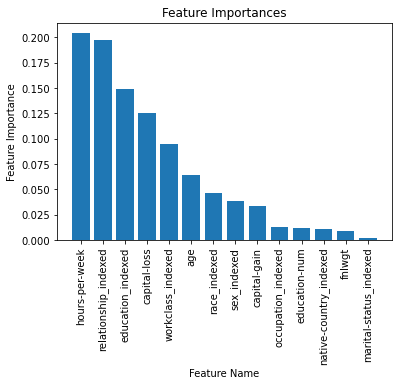

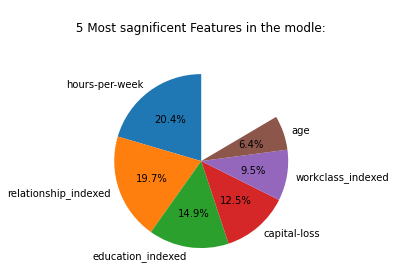

In [8]:
# Create a list of colors for the pie chart
values = [row[1] for row in sorted_importances]
names = [row[0] for row in sorted_importances]

# Create a bar chart of the feature importances
plt.bar(range(len(names)), values, align='center')
plt.xticks(range(len(names)), names, rotation='vertical')
plt.ylabel('Feature Importance')
plt.xlabel('Feature Name')
plt.title('Feature Importances')

# Display the bar chart
plt.show()



values = [row[1] for row in sorted_importances[:6]]
names = [row[0] for row in sorted_importances[:6]]
# Create a pie chart of the feature importances
plt.pie(values, labels=names, autopct='%1.1f%%', startangle=90,normalize=False)

# Add a title
plt.title("\n 5 Most sagnificent Features in the modle: \n")

# Display the pie chart
plt.show()

# GBTClassifier. 
Compare them in terms of accuracy, F1 score and AUC between the RandomForestClassifier and the GBTClassifier.

In [9]:
#Defining the Gradient Boosted Trees  GBT MODLE 
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxBins=50)

# Train the model on the training data
GBTmodel = gbt.fit(assembled_trainig_data)

# Generate predictions for the test data
predictions = GBTmodel.transform(assembled_test_data)

# Evaluate accuracy
evaluator_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
GBT_accuracy = evaluator_acc.evaluate(predictions)

# Evaluate F1 score
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
GBT_f1_score = evaluator_f1.evaluate(predictions)

GBT_auc = evaluator.evaluate(predictions, {evaluator_acc.metricName: 'areaUnderROC'})

print("the GBT classifier parameter's are: \n")
print('GBT model Accuracy:', GBT_accuracy)
print('F1 Score:', GBT_f1_score)
print('Area Under Curve:', GBT_auc)


the GBT classifier parameter's are: 

GBT model Accuracy: 0.8466830466830467
F1 Score: 0.8396737457914506
Area Under Curve: 0.9011632485566435


In [10]:

probabilities = predictions.select('probability') \
    .rdd.map(lambda x: (float(x[0][1]), 1.0 if x[0][1] >= x[0][0] else 0.0))
# Compute ROC curve and AUC
evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
roc = evaluator.evaluate(predictions)
# Print the AUC
print("Area under ROC = %g" % roc)



Area under ROC = 0.901163


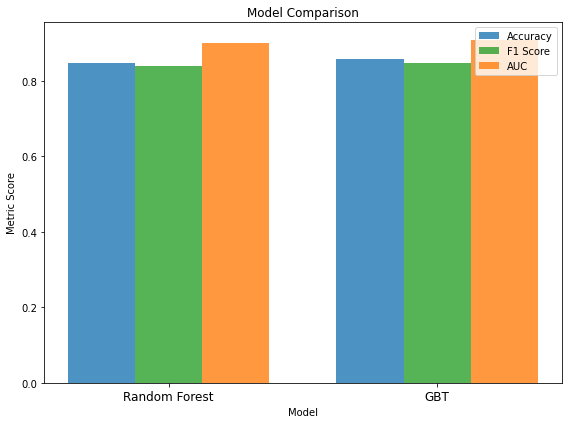

           Model  Accuracy  F1 Score       AUC
0  Random Forest  0.846683  0.839674  0.901163
1            GBT  0.858661  0.847938  0.909340


In [15]:
accuracy_values = [GBT_accuracy, RF_accuracy]
f1_values = [GBT_f1_score, RF_f1_score]
auc_values = [GBT_auc, RF_auc]


# Define the data
models = ["Random Forest", "GBT"]
accuracy = [GBT_accuracy, RF_accuracy]
f1_scores = [GBT_f1_score, RF_f1_score]
auc = [GBT_auc, RF_auc]

# Create a pandas DataFrame with the data
data = {
    "Model": models,
    "Accuracy": accuracy,
    "F1 Score": f1_scores,
    "AUC": auc
}

# Create the bar plot
fig, ax = plt.subplots(figsize=(8, 6))
bar_width = 0.25
opacity = 0.8
colors = ["tab:blue", "tab:green", "tab:orange"]
index = [0, 1]

rects1 = ax.bar(index, accuracy, bar_width, alpha=opacity, color=colors[0], label="Accuracy")
rects2 = ax.bar([i + bar_width for i in index], f1_scores,bar_width, alpha=opacity, color=colors[1], label="F1 Score")
rects3 = ax.bar([i + 2*bar_width for i in index], auc, bar_width, alpha=opacity, color=colors[2], label="AUC")

# Add labels, title, and legend
ax.set_xlabel("Model")
ax.set_ylabel("Metric Score")
ax.set_title("Model Comparison")
ax.set_xticks([i + bar_width for i in index])
ax.set_xticklabels(models)
ax.legend()

# Set the x-axis tick label font size
plt.xticks(fontsize=12)

# Set the gap between the bars
plt.subplots_adjust(wspace=0.25)

# Show the plot
plt.tight_layout()
plt.show()

# Define the data
models = ["BT", "andom Forest"]
accuracy = [GBT_accuracy, RF_accuracy]
f1_score= [GBT_f1_score, RF_f1_score]
auc = [GBT_auc, RF_auc]


df = pd.DataFrame(data)

print(df)

In [ ]:
# Create a list of classifiers and their names
classifiers = [best_rf_model, GBTmodel]
classifier_names = ['Random Forest', 'GBT']

# Create a figure to plot ROC curves
fig, ax = plt.subplots()

# Loop through each classifier
for i, clf in enumerate(classifiers):
    
    # Make predictions and obtain probabilities
    predictions = clf.transform(assembled_test_data)
    evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC")
    auc = evaluator.evaluate(predictions)
    probs = predictions.select('probability').rdd.map(lambda x: (float(x[0][1]), float(1.0 - x[0][1])))

    # Calculate ROC curve values
    y_test = assembled_test_data.select('label').rdd.map(lambda x: x[0]).take(10)
    fpr, tpr, thresholds = roc_curve(y_test, probs.map(lambda x: x[0]).take(10))
    
    # Plot ROC curve for current classifier
    ax.plot(fpr, tpr, label='{} ROC (AUC = {:.2f})'.format(classifier_names[i], auc))

# Add legend, title, and axis labels
ax.legend(loc="lower right")
ax.set_title('Receiver Operating Characteristic (ROC) Curves')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

# Show the plot
plt.show()

In [ ]:
spark.conf.set("spark.worker.timeout", "600s")
# Get the existing SparkContext
sc = SparkContext.getOrCreate()
# Stop the existing SparkContext
sc.stop()

